Generalising the LEP vs shower exploration to work on any two variables.

In [1]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [2]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [3]:
[c for c in day_data.columns if 'LEP' in c]

['circadian:basic:entries:LEP:temp',
 'circadian:basic:entries:LEP:datetimeSSM',
 'circadian:basic:entries:LEP:prominence',
 'circadian:combined:entries:LEP:temp',
 'circadian:combined:entries:LEP:datetimeSSM',
 'circadian:combined:entries:LEP:prominence',
 'circadian:combined:entries:LEP:minsSinceReadyToSleep',
 'circadian:combined:entries:LEP:minsUntilWake',
 'circadian:combined:entries:LEP:minsSinceSleep',
 'circadian:combined:entries:LEP:minsSinceSunsetEnd',
 'circadian:combined:entries:LEP:minsSinceSunriseEnd',
 'circadian:basic:entries:LEP:temp:vsDayMinus1',
 'circadian:basic:entries:LEP:temp:onDayMinus1',
 'circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1',
 'circadian:basic:entries:LEP:datetimeSSM:onDayMinus1',
 'circadian:basic:entries:LEP:prominence:vsDayMinus1',
 'circadian:basic:entries:LEP:prominence:onDayMinus1',
 'circadian:combined:entries:LEP:temp:vsDayMinus1',
 'circadian:combined:entries:LEP:temp:onDayMinus1',
 'circadian:combined:entries:LEP:datetimeSSM:vsDayMinu

Good pairs:

col1 = 'bedroomEnvironment:bedroomTemp:betweenReadyToSleepAndWake:average'
col2 = 'night:yasa:adjusted:deepSleepSecs'

col1 = 'events:shower:lastSSM'
col2 = 'circadian:combined:entries:LEP:datetimeSSM'


In [13]:
col1 ='night:aggregated:deepSleepSecs'
col2 = 'ereader:gotIntoBedToAsleep:endTimeSSM'

columns_to_select = [col1, col2]

df = day_data.copy()[columns_to_select]
df.index = day_data['dayAndNightOf']
import notebooks.Util.Time as Time
reload(Time)
df = Time.convert_cols_to_hours(df)

c1 = Time.convert_col_name(col1)
c2 = Time.convert_col_name(col2)
df = df[df[c1].notna() & df[c2].notna()]
df['Diff'] = df[c2] - df[c1]

df_orig = df.copy()

df.head()

,night:aggregated:deepSleepHours,ereader:gotIntoBedToAsleep:endTimeHSM,Diff
dayAndNightOf,,,
2025-02-16,2.166667,21.972222,19.805556
2025-03-05,1.733333,22.766111,21.032778
2025-03-06,0.816667,22.691389,21.874722
2025-03-03,0.700000,23.414722,22.714722
2025-03-02,1.416667,22.860833,21.444167


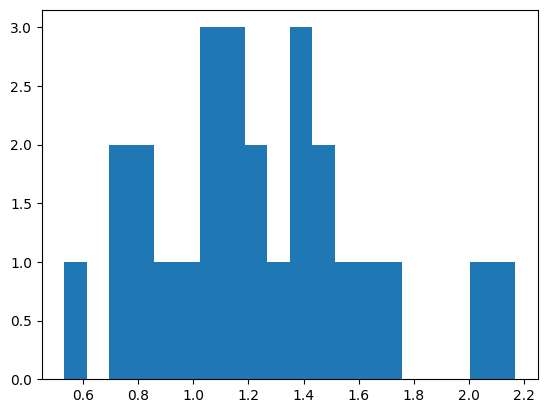

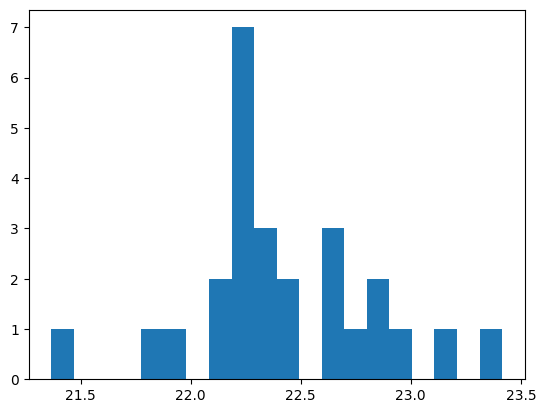

In [14]:
import matplotlib.pyplot as plt

plt.hist(df[c1], bins=20)
plt.show()

plt.hist(df[c2], bins=20)
plt.show()

# Outlier removal

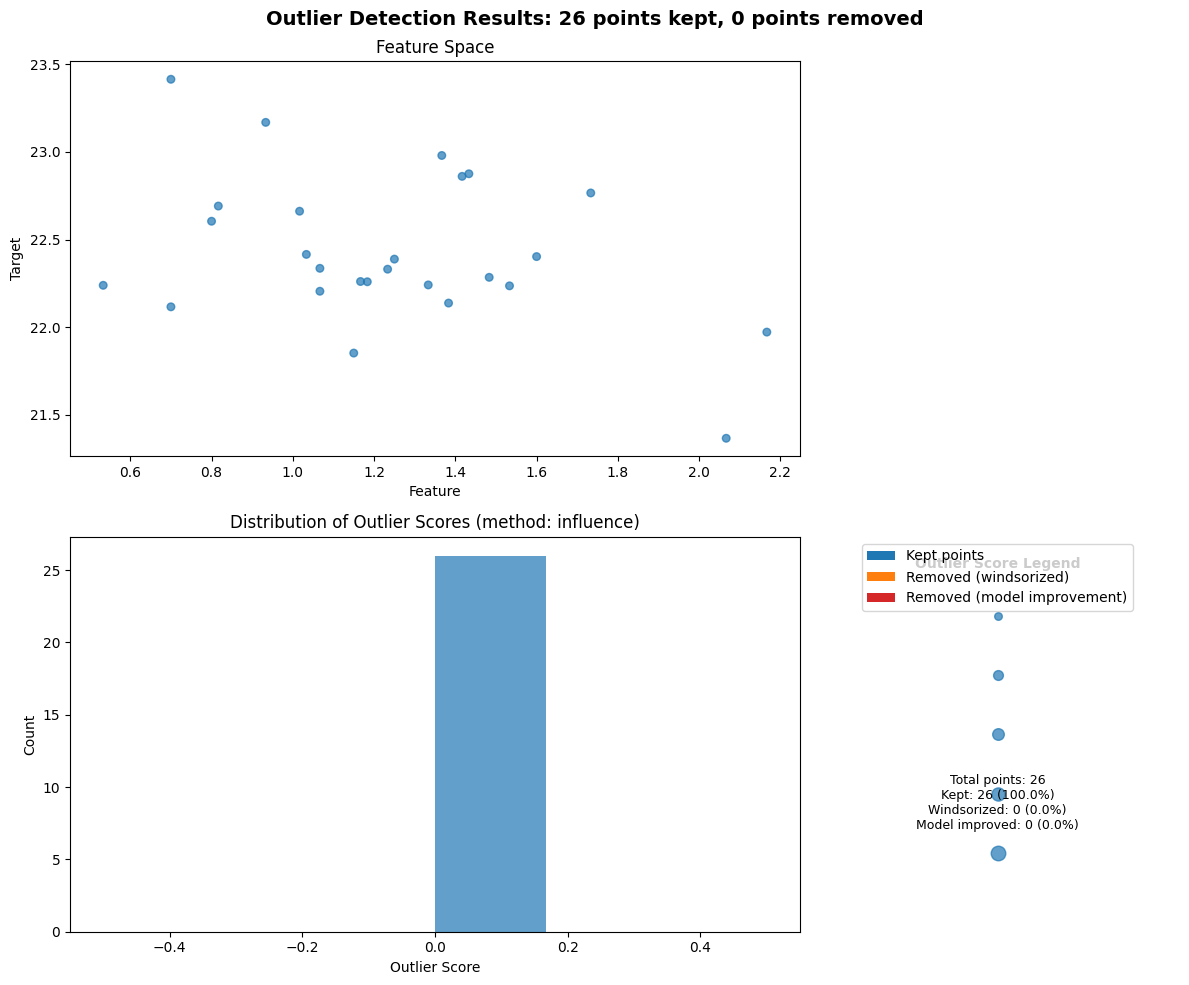

In [15]:
import stats_outliers
reload(stats_outliers)


X = df_orig[c1].values.reshape(-1, 1)
y = df_orig[c2].values
method = 'influence'
_, _, mask, outlier_scores = stats_outliers.remove_std_outliers(X, y, std_threshold=3)
fig = stats_outliers.plot_outlier_detection(X, y, mask, outlier_scores, method=method)

df = df.loc[mask]


# Clustering

In [7]:
import stats_clustering
reload(stats_clustering)

clusters = stats_clustering.cluster_fastcluster_wrapper(df, c1, c2)




In [8]:
display(clusters.name)
print("Labels: ", clusters.labels[0:5], "...")
print("Probs: ", clusters.probs[0:2], "...")
print("Means: ", clusters.probs[0:2], "...")
print("covariances: ", clusters.covariances[0:1], "...")
print("weights: ", clusters.weights[0:2], "...")

'Hierarchical Clustering (fastcluster - ward)'

Labels:  [2 1 0 1 1] ...
Probs:  [[0.25362704 0.19073249 0.55564047]
 [0.34306479 0.428997   0.22793821]] ...
Means:  [[0.25362704 0.19073249 0.55564047]
 [0.34306479 0.428997   0.22793821]] ...
covariances:  [[[ 0.08363562 -0.0112362 ]
  [-0.0112362   0.04065267]]] ...
weights:  [0.07692308 0.23076923] ...


In [9]:
import stats_clustering
reload(stats_clustering)

clusters = stats_clustering.analyze_pair_best(df, c1, c2)

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [10]:
def print_pair_analysis(pair_result):
    print(f"Analysis for {pair_result.feat1} vs {pair_result.feat2}")
    orr = pair_result.overall_regression
    print(f"Overall Regression: slope={orr.slope:.3f} (CI={orr.slope_ci[0]:.3f}-{orr.slope_ci[1]:.3f}), intercept={orr.intercept:.3f} (CI={orr.intercept_ci[0]:.3f}-{orr.intercept_ci[1]:.3f}), R2={orr.r2:.3f}, p_slope={orr.slope_p_value:.3g}, p_intercept={orr.intercept_p_value:.3g}")
    print(f"Overall Spearman: rho={pair_result.overall_spearman_rho:.3f}, p={pair_result.overall_spearman_p:.3g}")
    a = pair_result.anova
    print(f"ANOVA: F={a.f_value:.3f}, p={a.p_value:.2f}")
    for lbl, mean in a.cluster_means.items():
        std = a.cluster_stds[lbl]
        print(f" Cluster {lbl}: mean={mean:.3f}, std={std:.3f}")
    for c in pair_result.clusters:
        print(f"Cluster {c.label}: size={c.size}, x_range={c.x_range[0]:.3f}-{c.x_range[1]:.3f}, y_range={c.y_range[0]:.3f}-{c.y_range[1]:.3f}, y_mean={c.y_mean:.3f}, y_std={c.y_std:.3f}")
        reg = c.regression
        print(f" Regression: slope={reg.slope:.3f} (CI={reg.slope_ci[0]:.3f}-{reg.slope_ci[1]:.3f}), intercept={reg.intercept:.3f} (CI={reg.intercept_ci[0]:.3f}-{reg.intercept_ci[1]:.3f}), R2={reg.r2:.3f}, p_slope={reg.slope_p_value:.3g}, p_intercept={reg.intercept_p_value:.3g}")
        print(f" Spearman: rho={c.spearman_rho:.3f}, p={c.spearman_p:.2f}")

print_pair_analysis(clusters)

Analysis for night:aggregated:deepSleepHours vs ereader:gotIntoBedToAsleep:endTimeHSM
Overall Regression: slope=-0.418 (CI=-0.840-0.004), intercept=22.943 (CI=22.396-23.490), R2=0.149, p_slope=0.0518, p_intercept=1.8e-31
Overall Spearman: rho=-0.193, p=0.344
ANOVA: F=33.791, p=0.00
 Cluster 0: mean=22.315, std=0.196
 Cluster 1: mean=23.011, std=0.220
 Cluster 2: mean=21.669, std=0.303
Cluster 0: size=18, x_range=0.533-1.600, y_range=21.852-22.691, y_mean=22.315, y_std=0.196
 Regression: slope=-0.134 (CI=-0.497-0.228), intercept=22.467 (CI=22.044-22.889), R2=0.037, p_slope=0.444, p_intercept=1.22e-24
 Spearman: rho=-0.148, p=0.56
Cluster 1: size=6, x_range=0.700-1.733, y_range=22.766-23.415, y_mean=23.011, y_std=0.220
 Regression: slope=-0.625 (CI=-0.808--0.442), intercept=23.801 (CI=23.561-24.040), R2=0.957, p_slope=0.000688, p_intercept=1.04e-09
 Spearman: rho=-0.943, p=0.00
Cluster 2: size=2, x_range=2.067-2.167, y_range=21.366-21.972, y_mean=21.669, y_std=0.303
 Regression: slope=6.


--- Comparing clustering methods on night:aggregated:deepSleepHours vs ereader:gotIntoBedToAsleep:endTimeHSM ---

Running Fastcluster (Ward)...
  Found 3 final clusters
  Fastcluster (Ward) completed in 0.0007 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


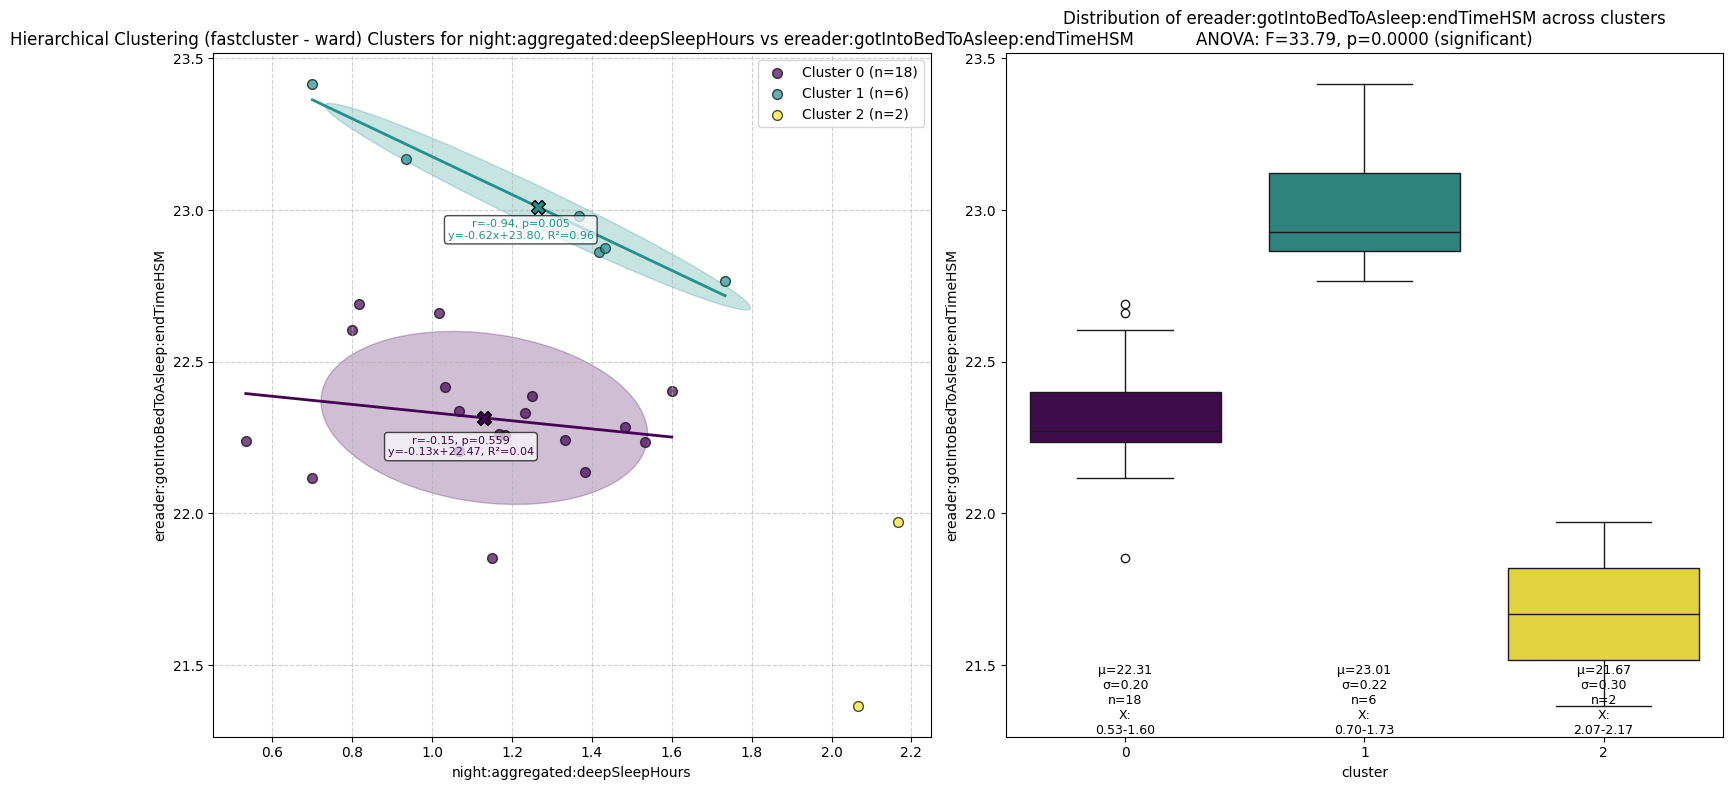

  ANOVA results for Fastcluster (Ward):
    F-value: 33.7910
    p-value: 0.0000
    Significant difference: True
    Tukey HSD post-hoc test:

Running Fastcluster (Single)...
  Found 3 final clusters
  Fastcluster (Single) completed in 0.0324 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:1367: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariances = np.array([np.cov(X[labels == i].T) for i in unique_labels])
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported typ

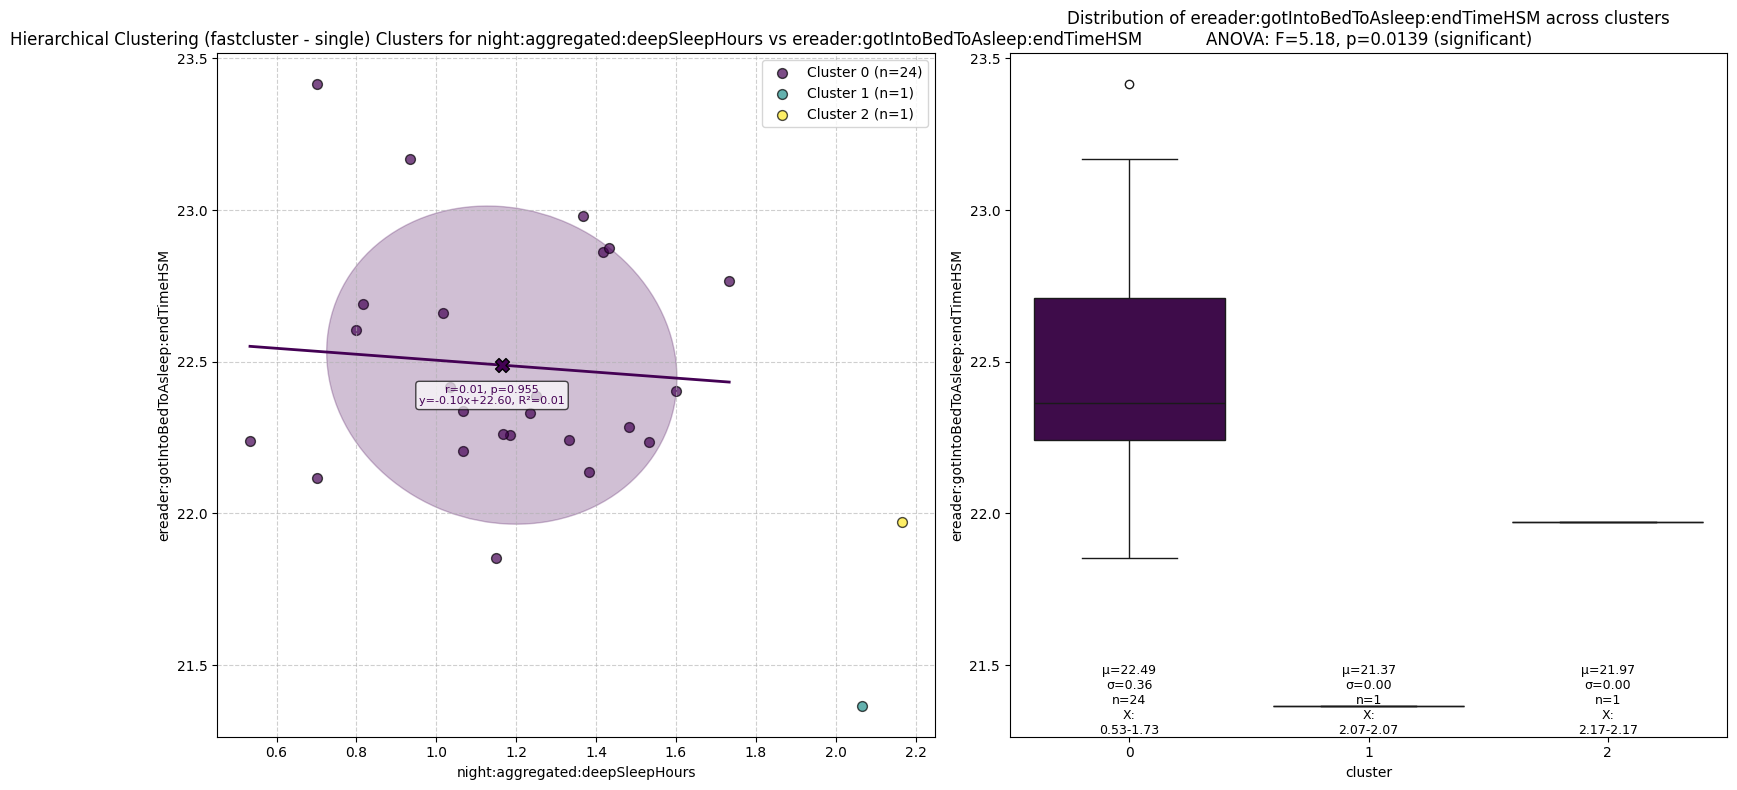

  ANOVA results for Fastcluster (Single):
    F-value: 5.1768
    p-value: 0.0139
    Significant difference: True
    Tukey HSD post-hoc test:

Running Fastcluster (Complete)...
  Found 3 final clusters
  Fastcluster (Complete) completed in 0.0006 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


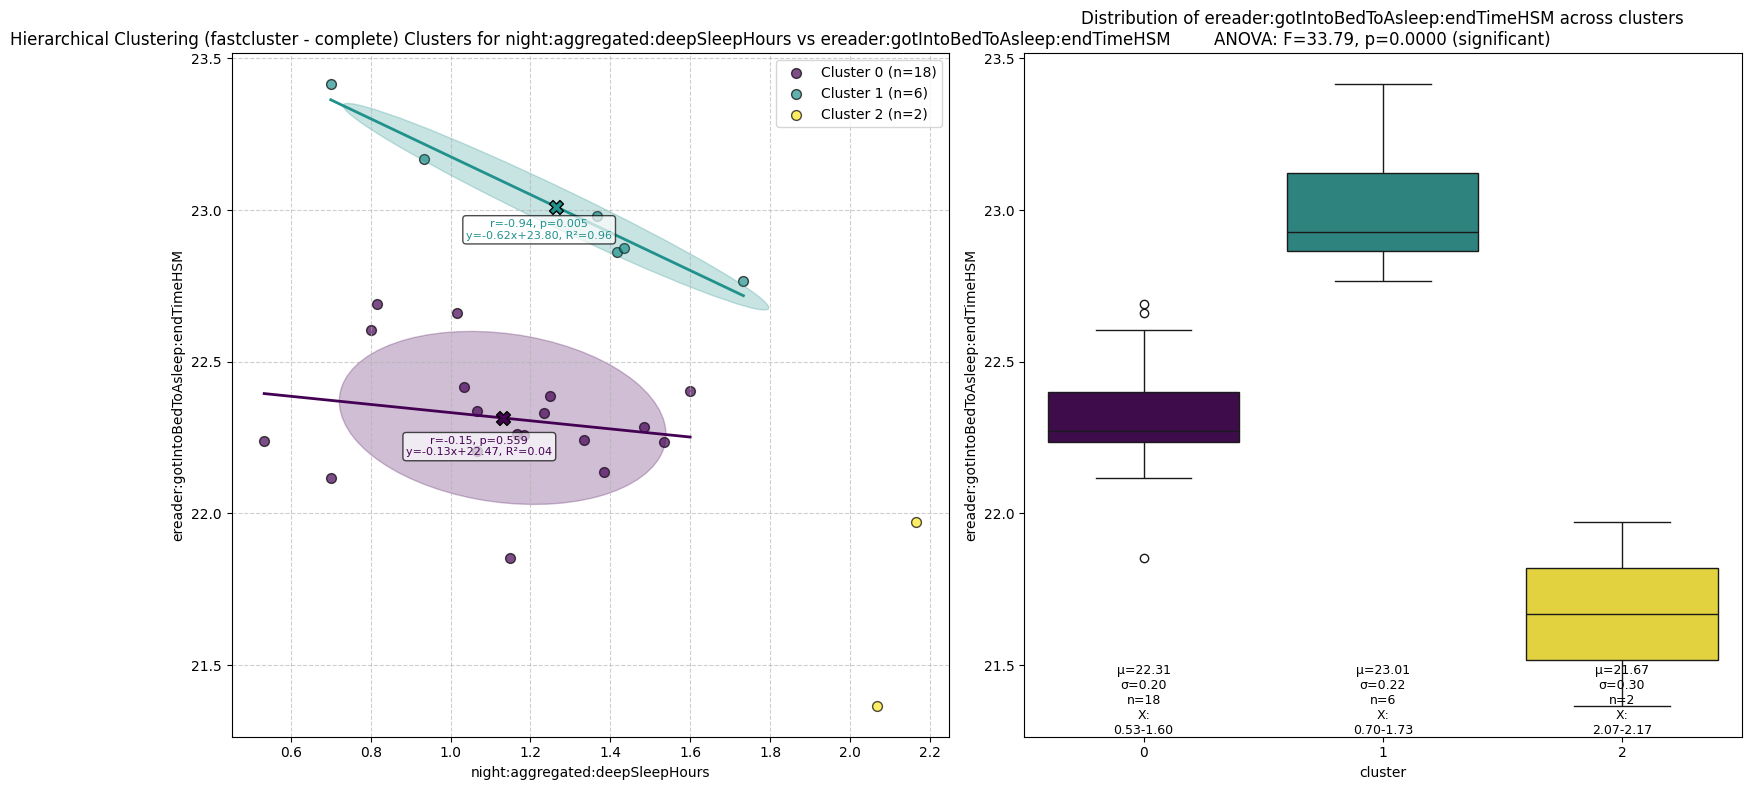

  ANOVA results for Fastcluster (Complete):
    F-value: 33.7910
    p-value: 0.0000
    Significant difference: True
    Tukey HSD post-hoc test:

Running Fastcluster (Average)...
  Found 3 final clusters
  Fastcluster (Average) completed in 0.0005 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


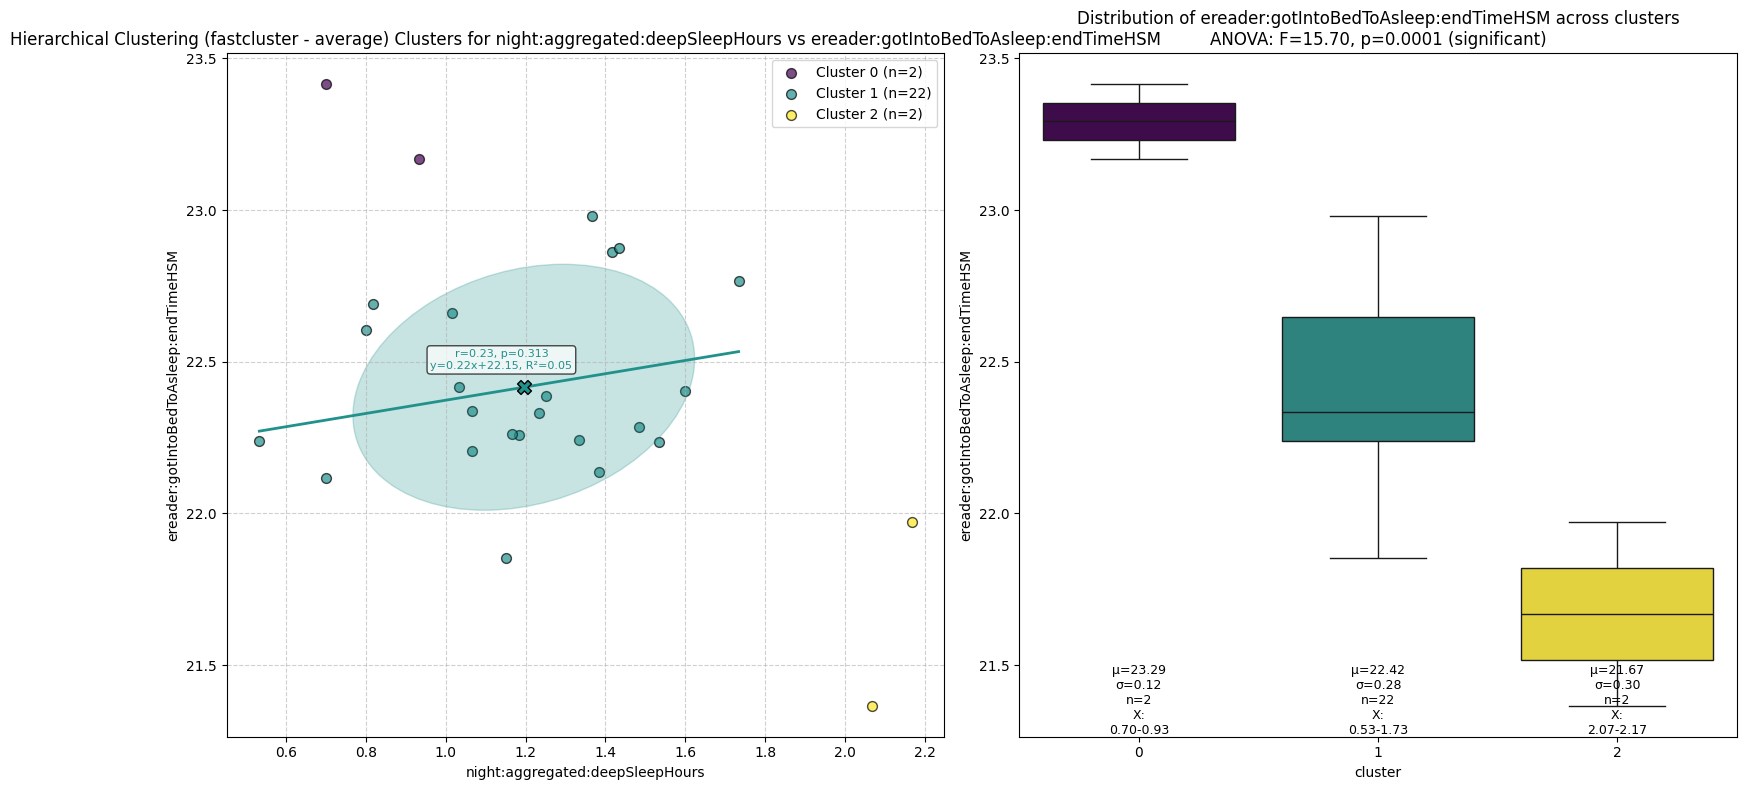

  ANOVA results for Fastcluster (Average):
    F-value: 15.6974
    p-value: 0.0001
    Significant difference: True
    Tukey HSD post-hoc test:

Running Fastcluster (Centroid)...
  Found 3 final clusters
  Fastcluster (Centroid) completed in 0.0007 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


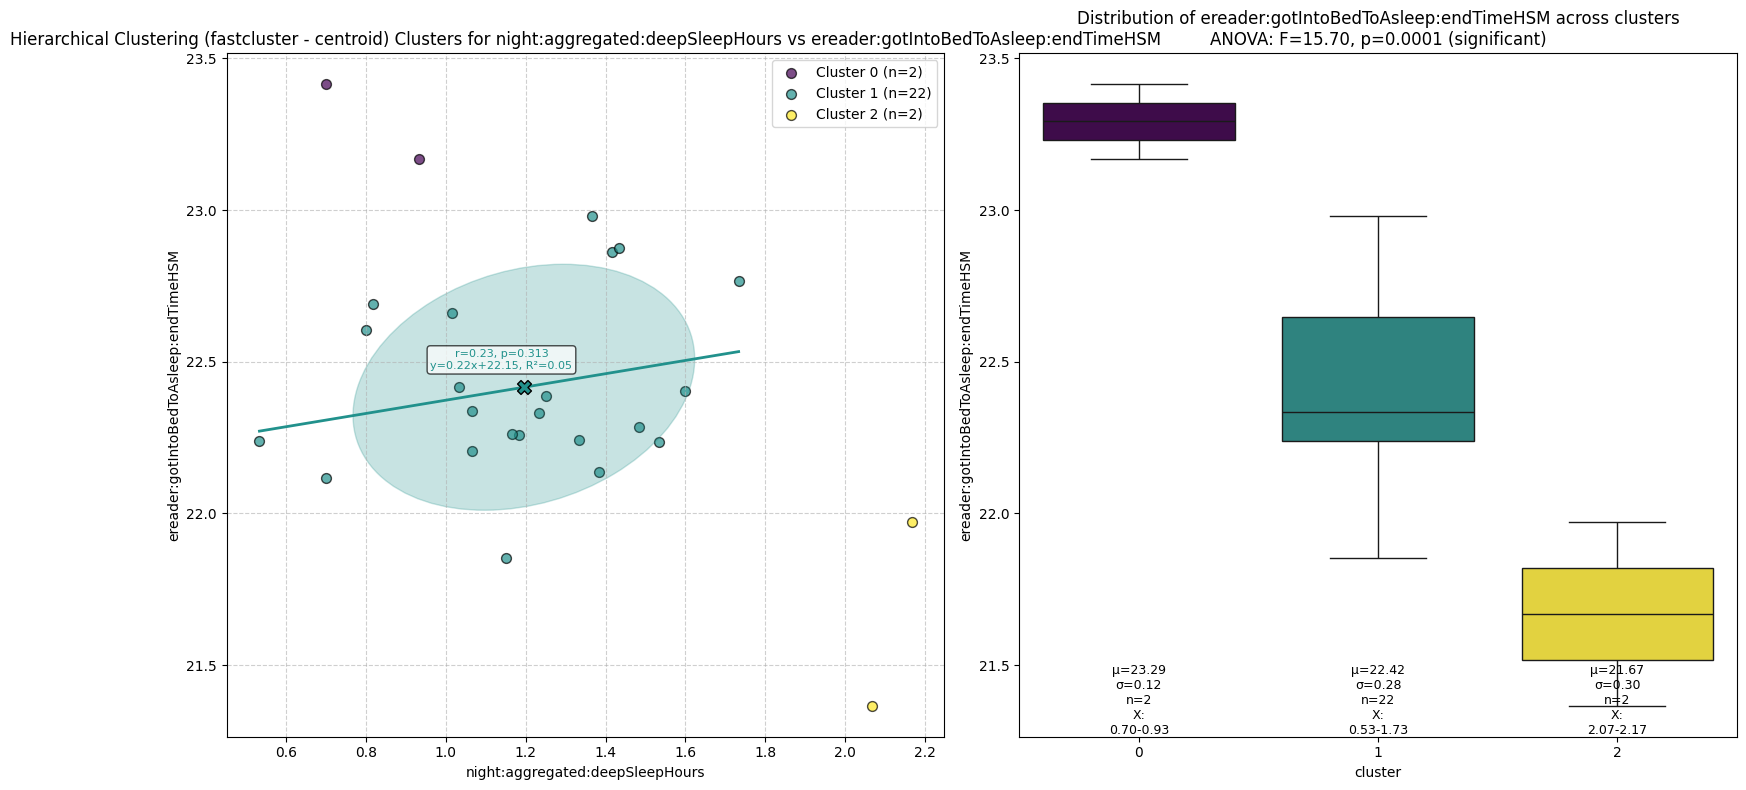

  ANOVA results for Fastcluster (Centroid):
    F-value: 15.6974
    p-value: 0.0001
    Significant difference: True
    Tukey HSD post-hoc test:

Running Fastcluster (Median)...
  Found 3 final clusters
  Fastcluster (Median) completed in 0.0008 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


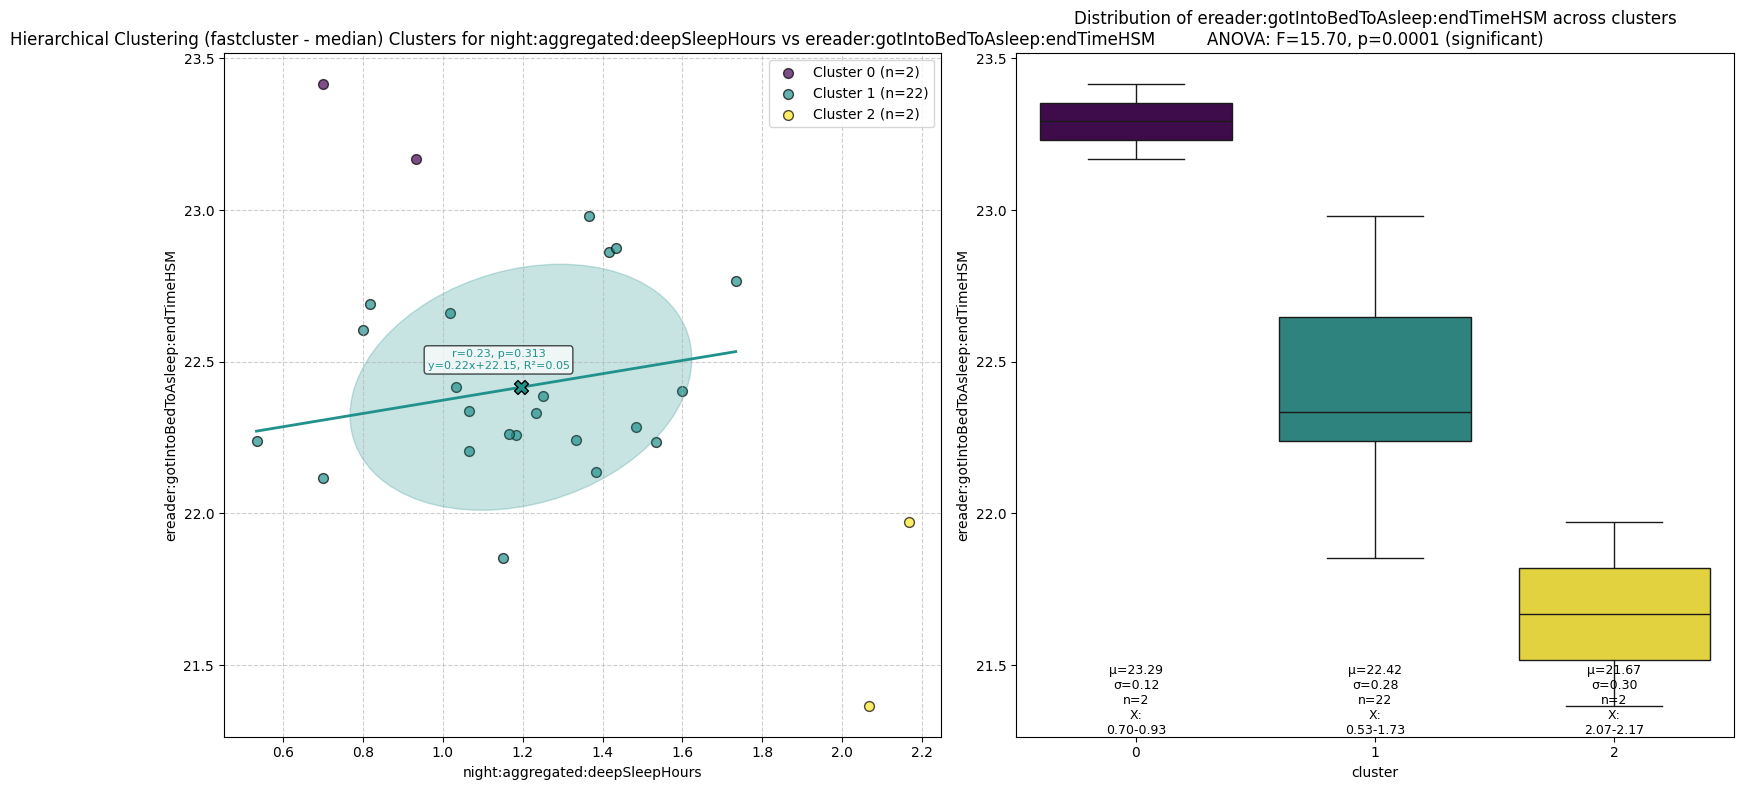

  ANOVA results for Fastcluster (Median):
    F-value: 15.6974
    p-value: 0.0001
    Significant difference: True
    Tukey HSD post-hoc test:

Running GMM...
  Found 3 final clusters
  GMM completed in 0.1444 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


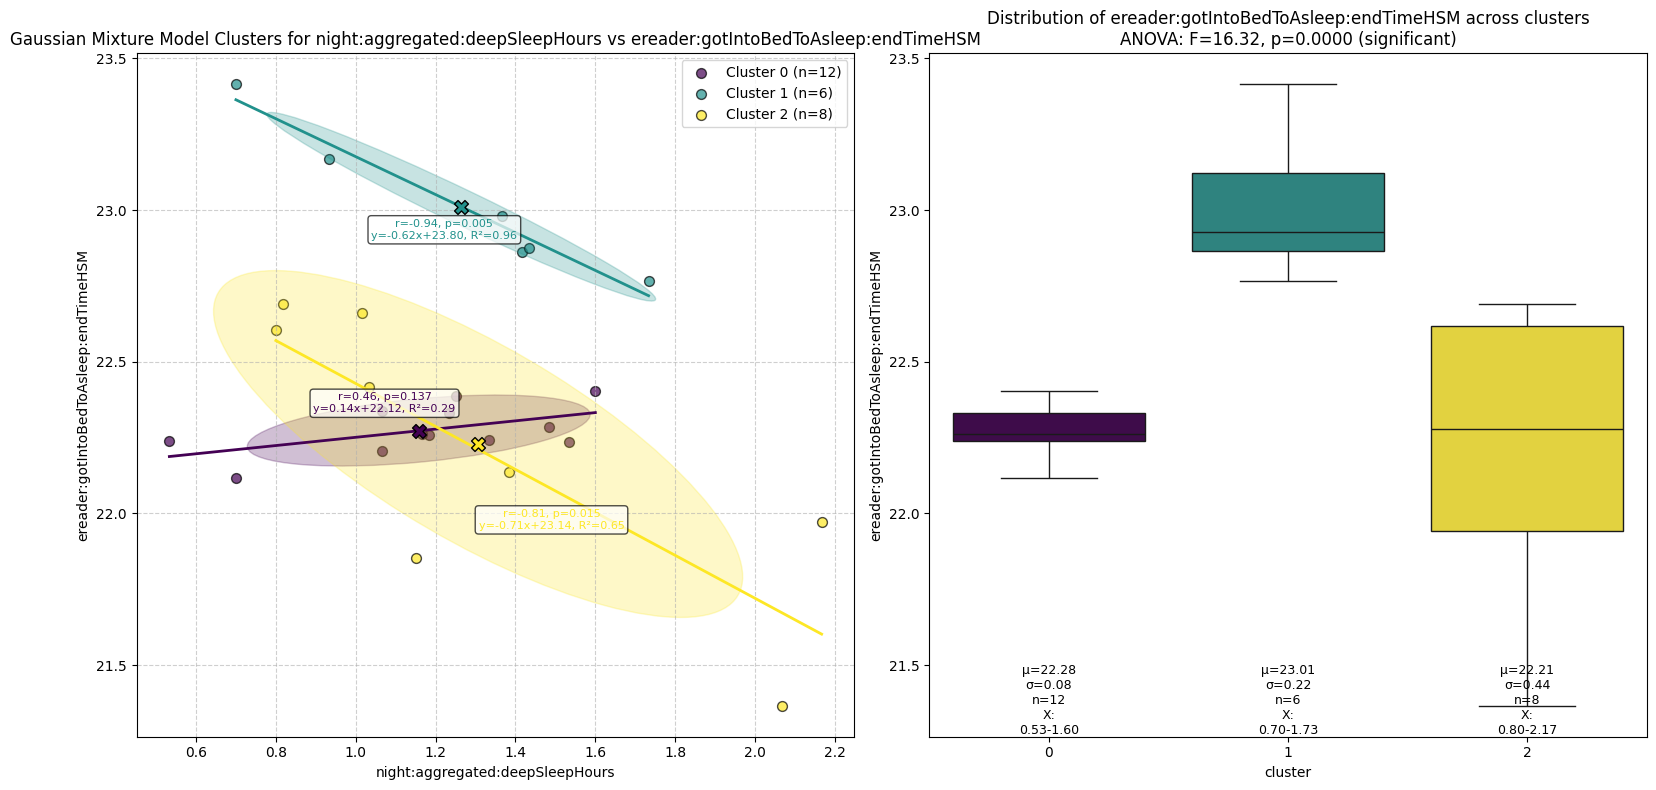

  ANOVA results for GMM:
    F-value: 16.3191
    p-value: 0.0000
    Significant difference: True
    Tukey HSD post-hoc test:

Running Mixture of t...
  Found 3 final clusters
  Mixture of t completed in 0.0151 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


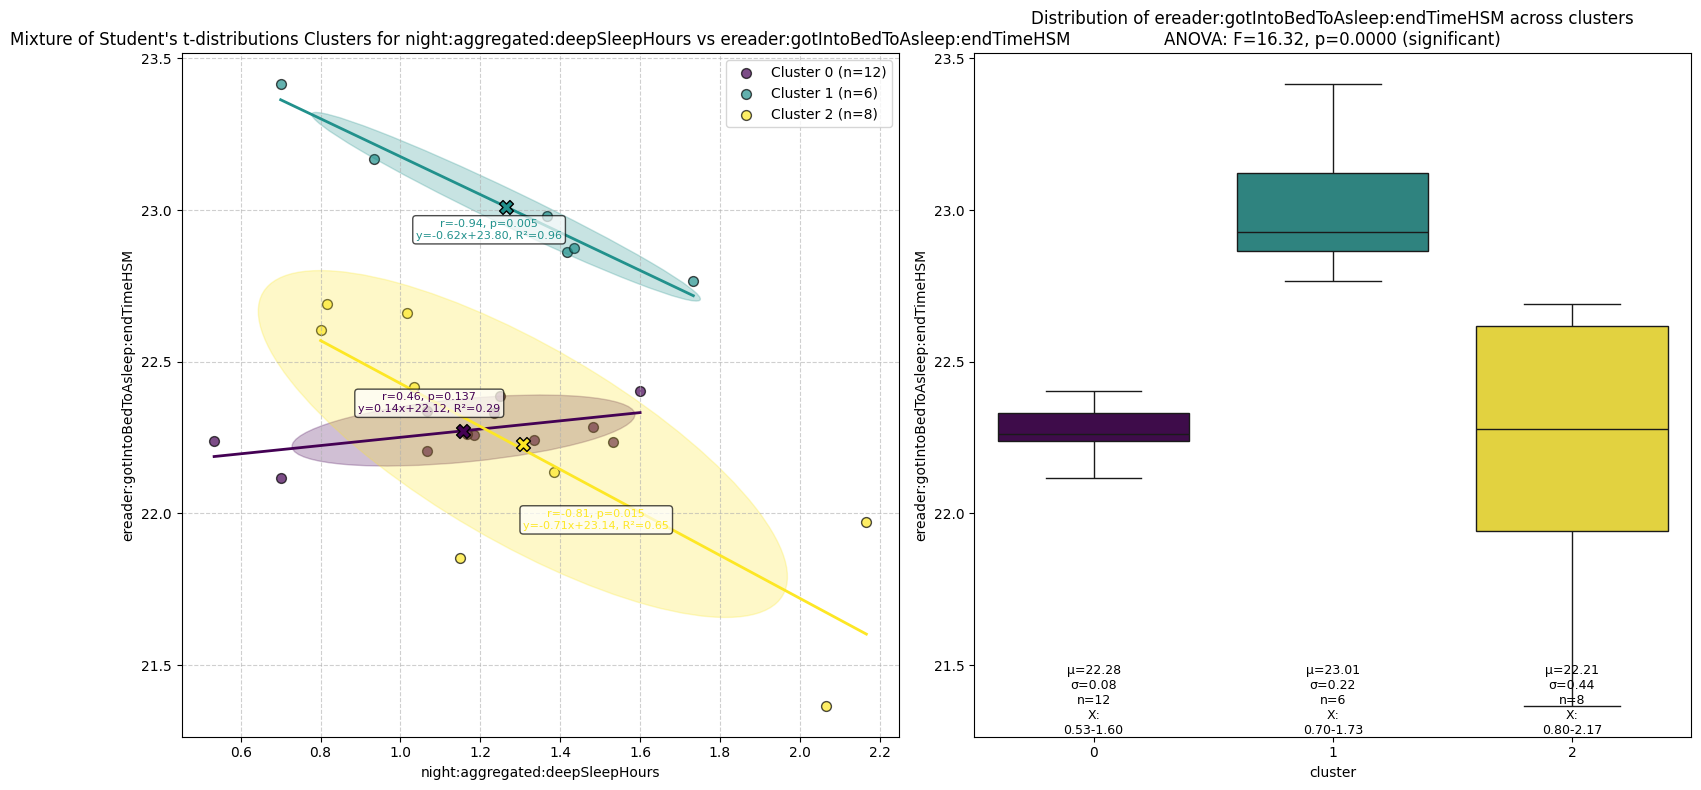

  ANOVA results for Mixture of t:
    F-value: 16.3191
    p-value: 0.0000
    Significant difference: True
    Tukey HSD post-hoc test:

Running DPMM...
  Method automatically determines optimal clusters
  Found 1 final clusters
  DPMM completed in 0.1337 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


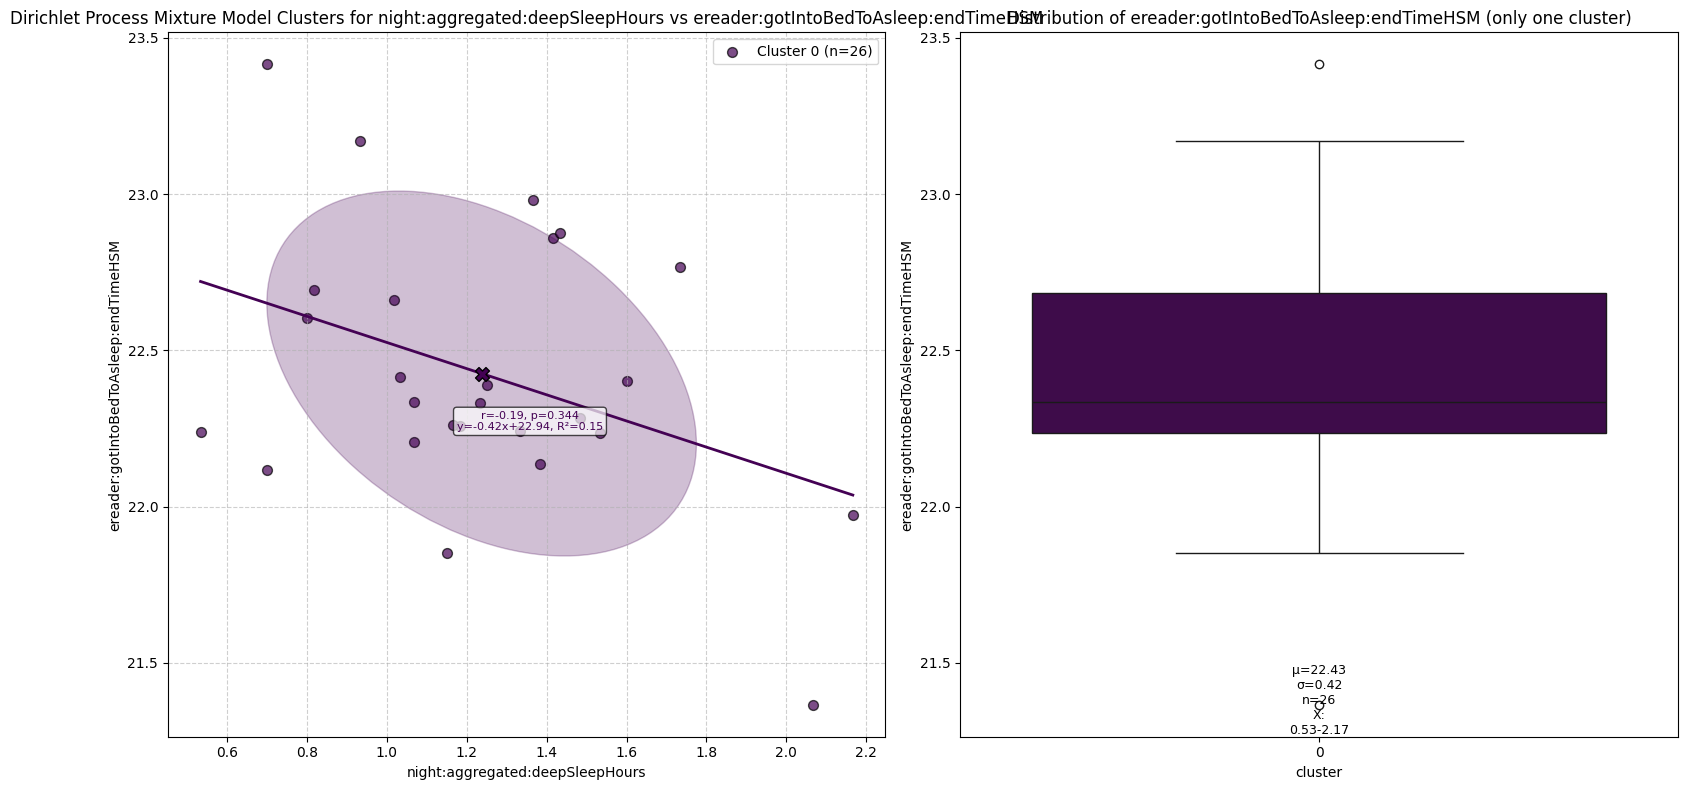

  ANOVA analysis not possible for DPMM

Running Variational DPMM...
  Method automatically determines optimal clusters
  Found 2 final clusters
  Variational DPMM completed in 0.1000 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


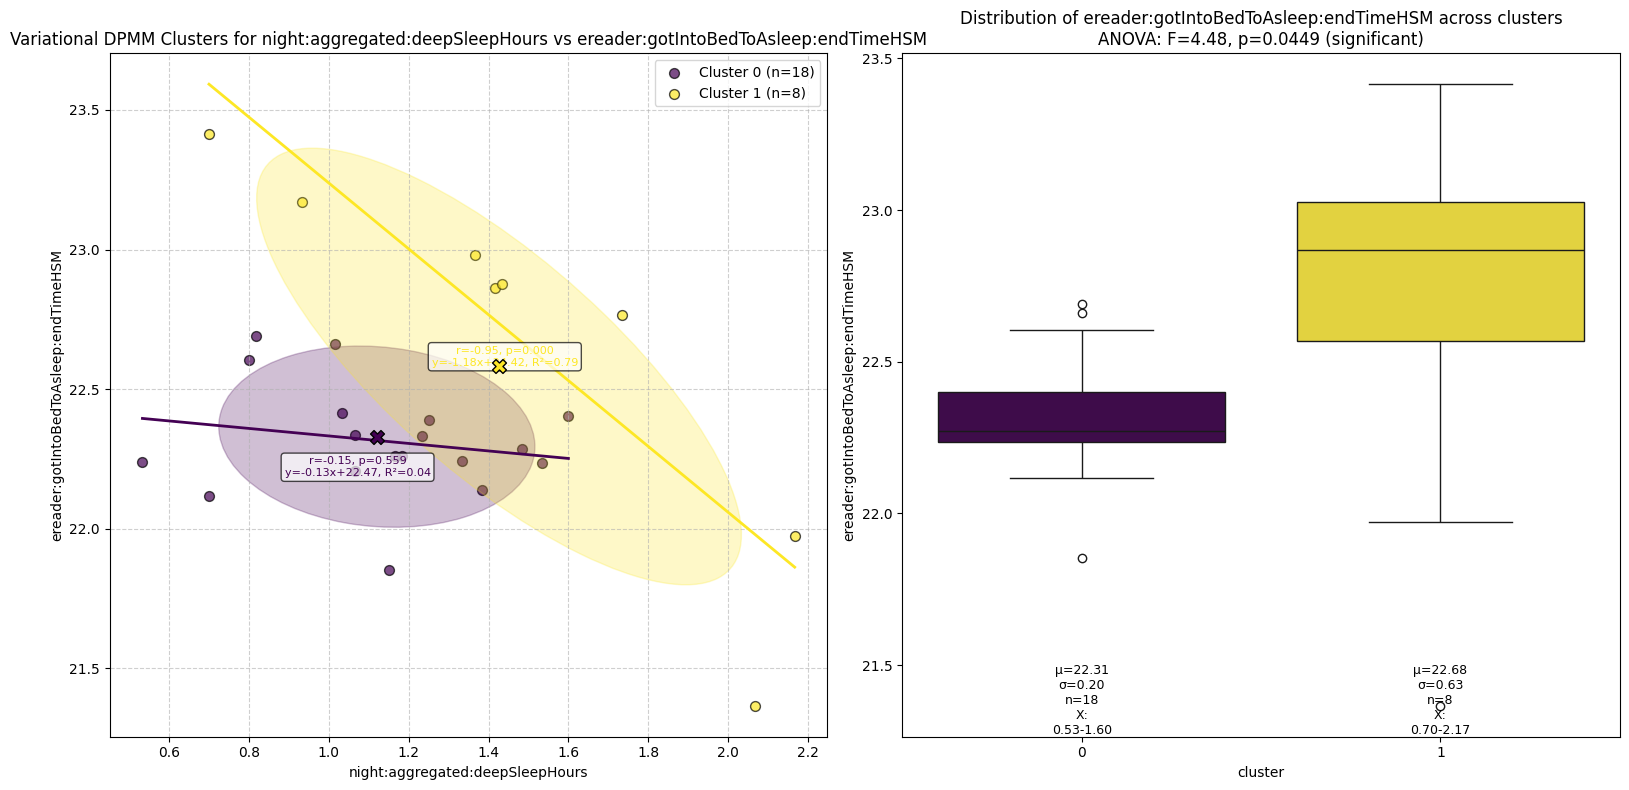

  ANOVA results for Variational DPMM:
    F-value: 4.4775
    p-value: 0.0449
    Significant difference: True
    Tukey HSD post-hoc test:

Running X-means...
  Method automatically determines optimal clusters
  Found 3 final clusters
  X-means completed in 0.2222 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


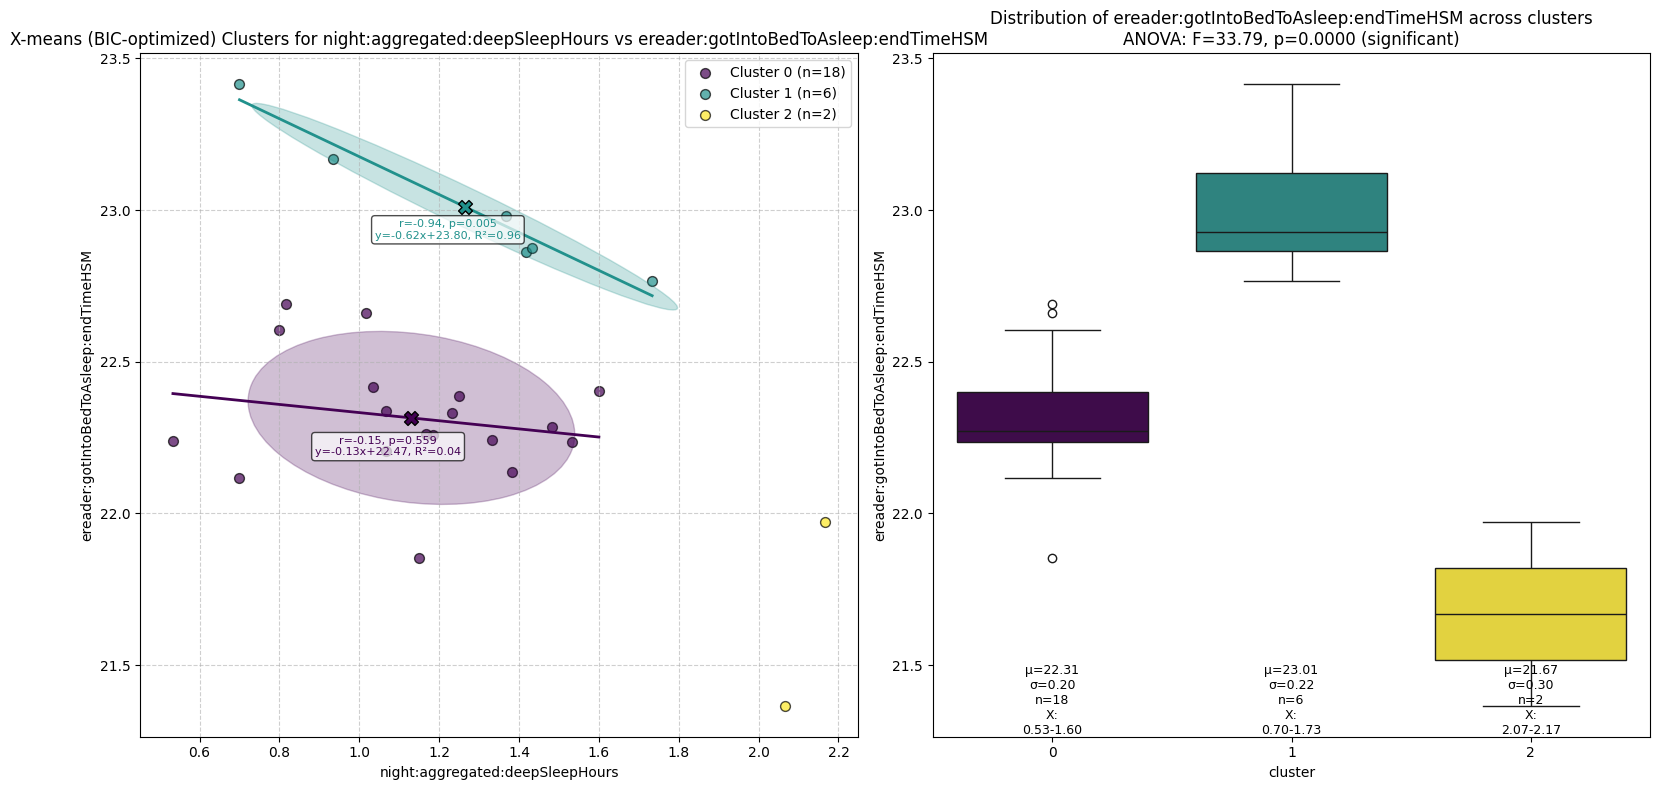

  ANOVA results for X-means:
    F-value: 33.7910
    p-value: 0.0000
    Significant difference: True
    Tukey HSD post-hoc test:

Running HDBSCAN...
  Method automatically determines optimal clusters
  Found 1 final clusters
  HDBSCAN completed in 0.0131 seconds
  Visualizing clustering results with ANOVA...


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=

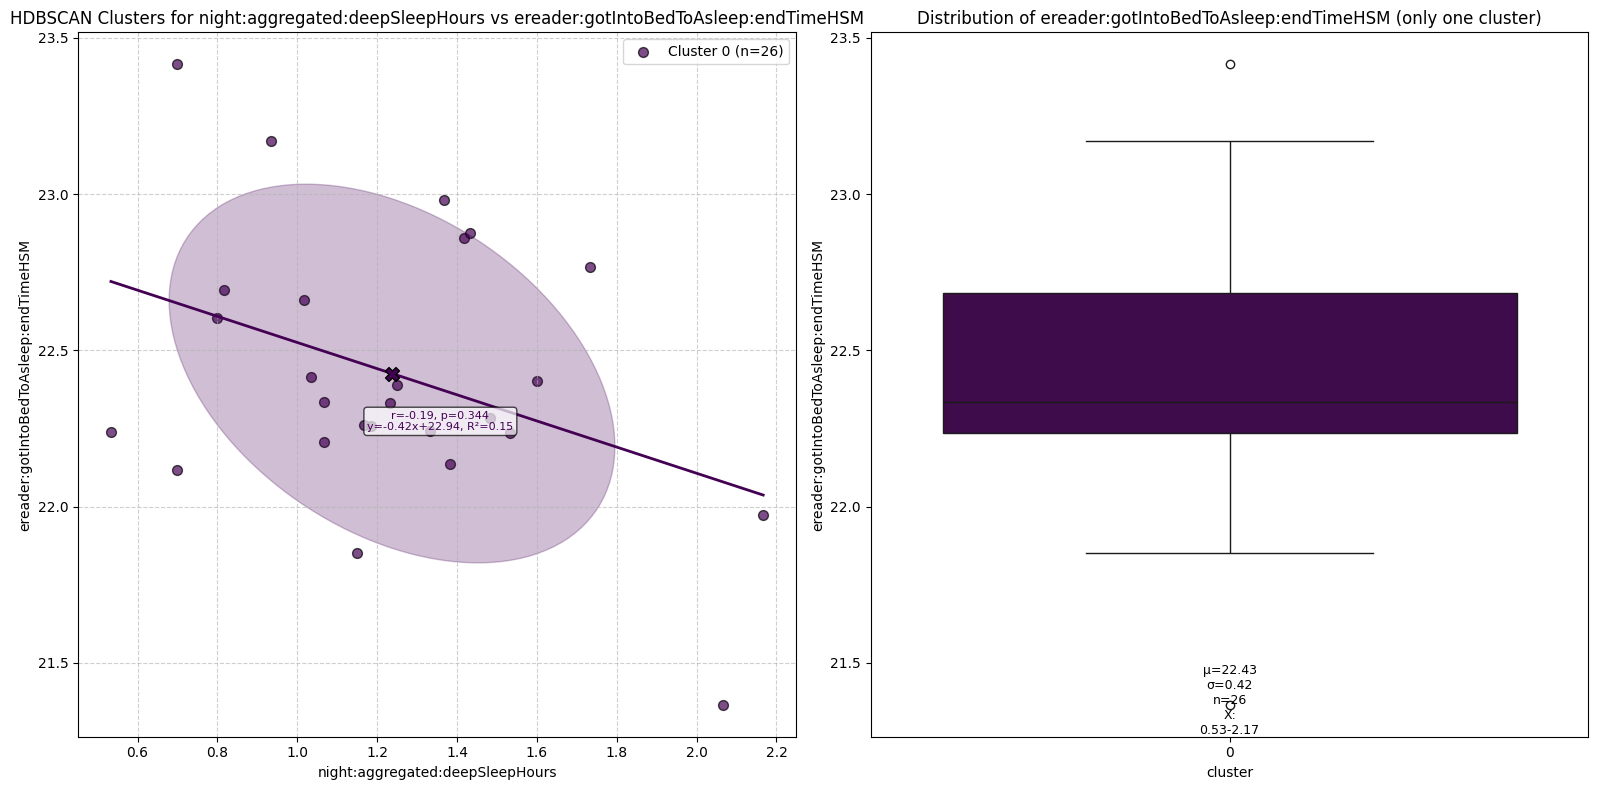

  ANOVA analysis not possible for HDBSCAN

Running Affinity Prop....
  Method automatically determines optimal clusters
  Found 8 final clusters
  Affinity Prop. completed in 0.0060 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


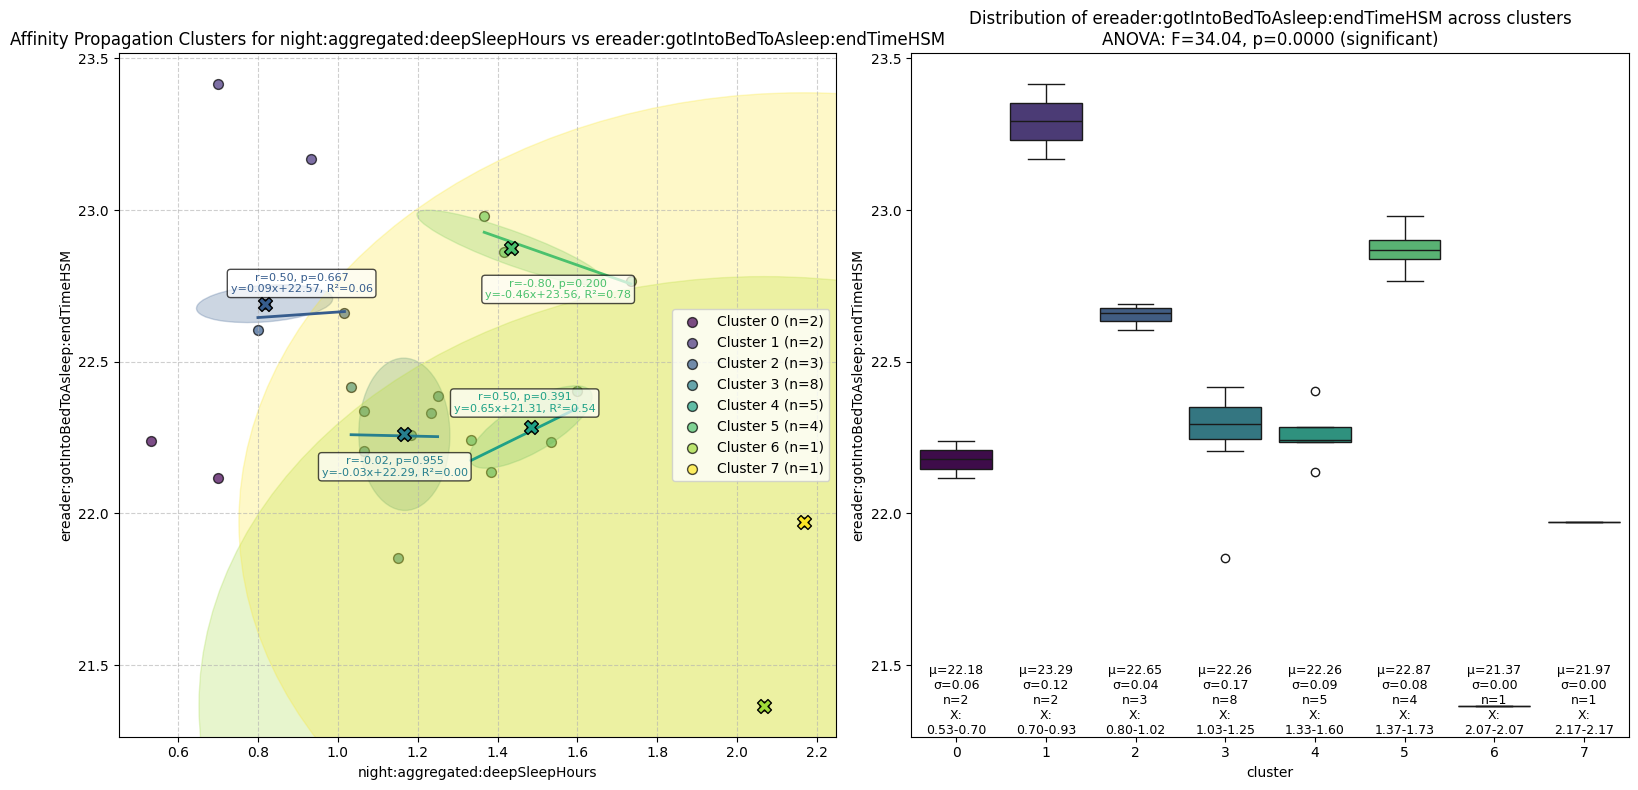

  ANOVA results for Affinity Prop.:
    F-value: 34.0376
    p-value: 0.0000
    Significant difference: True
    Tukey HSD post-hoc test:

Running KDE-Based...
  Found 3 final clusters
  KDE-Based completed in 0.0068 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


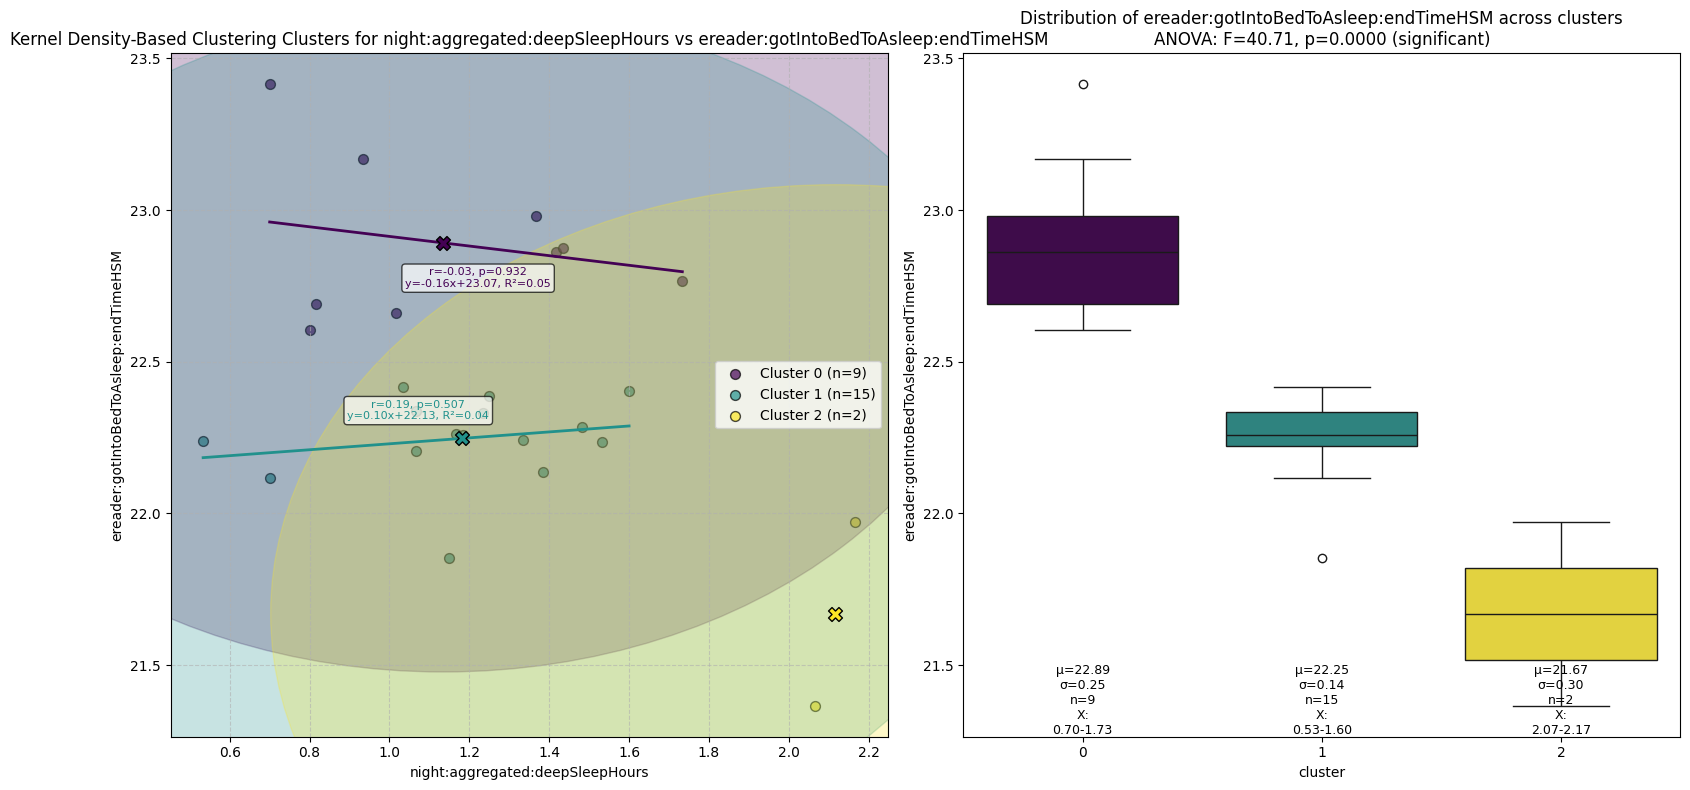

  ANOVA results for KDE-Based:
    F-value: 40.7063
    p-value: 0.0000
    Significant difference: True
    Tukey HSD post-hoc test:

Running Fuzzy C-Means...
  Found 3 final clusters
  Fuzzy C-Means completed in 0.0164 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


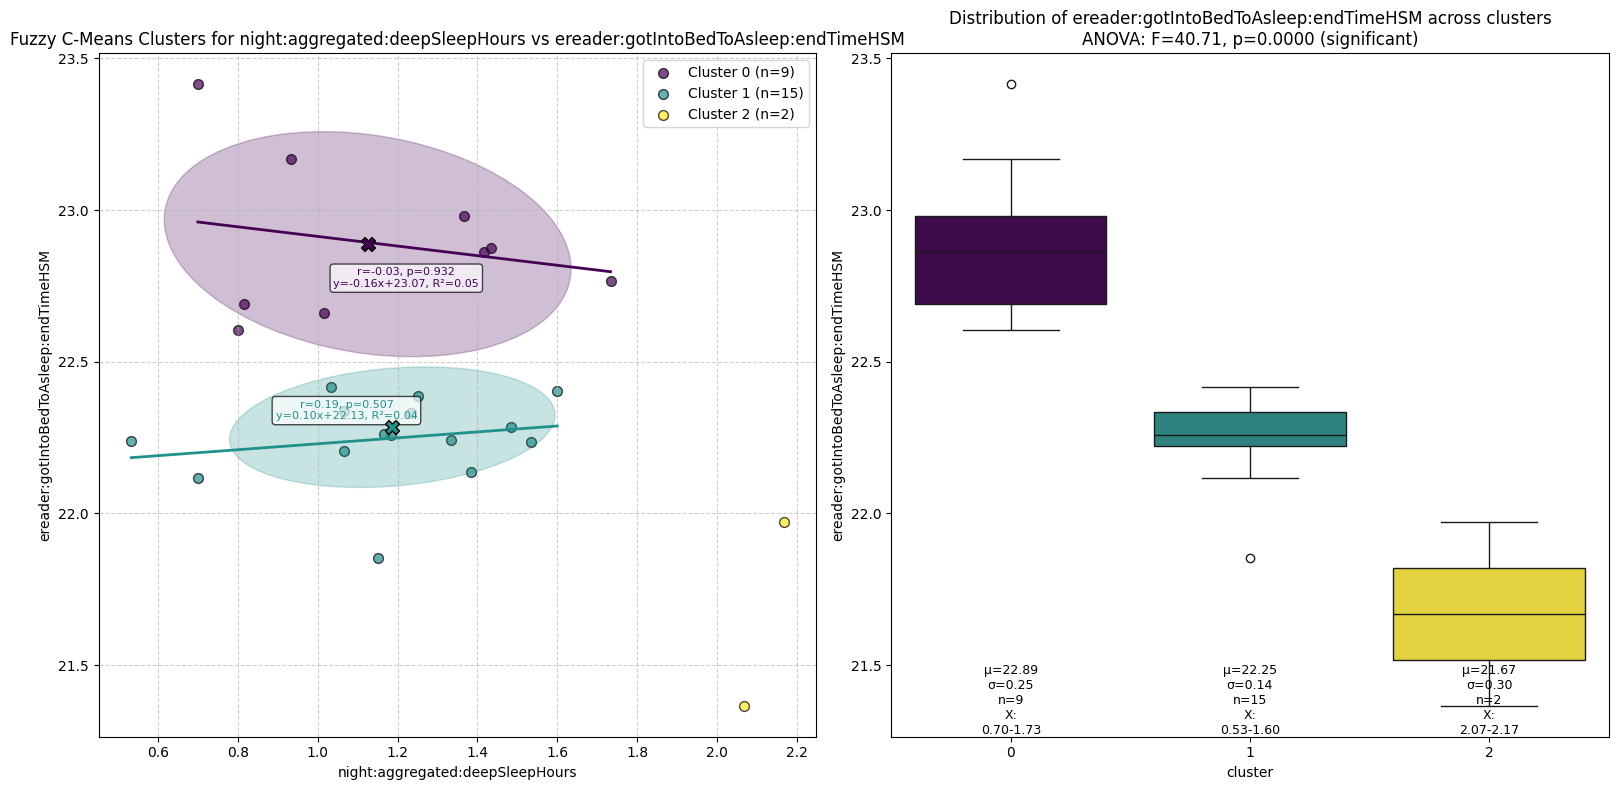

  ANOVA results for Fuzzy C-Means:
    F-value: 40.7063
    p-value: 0.0000
    Significant difference: True
    Tukey HSD post-hoc test:

Running Spectral Prob...
  Found 3 final clusters
  Spectral Prob completed in 0.0500 seconds
  Visualizing clustering results with ANOVA...


c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:2793: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=plot_df, ax=ax_box, palette=distinct_colors)


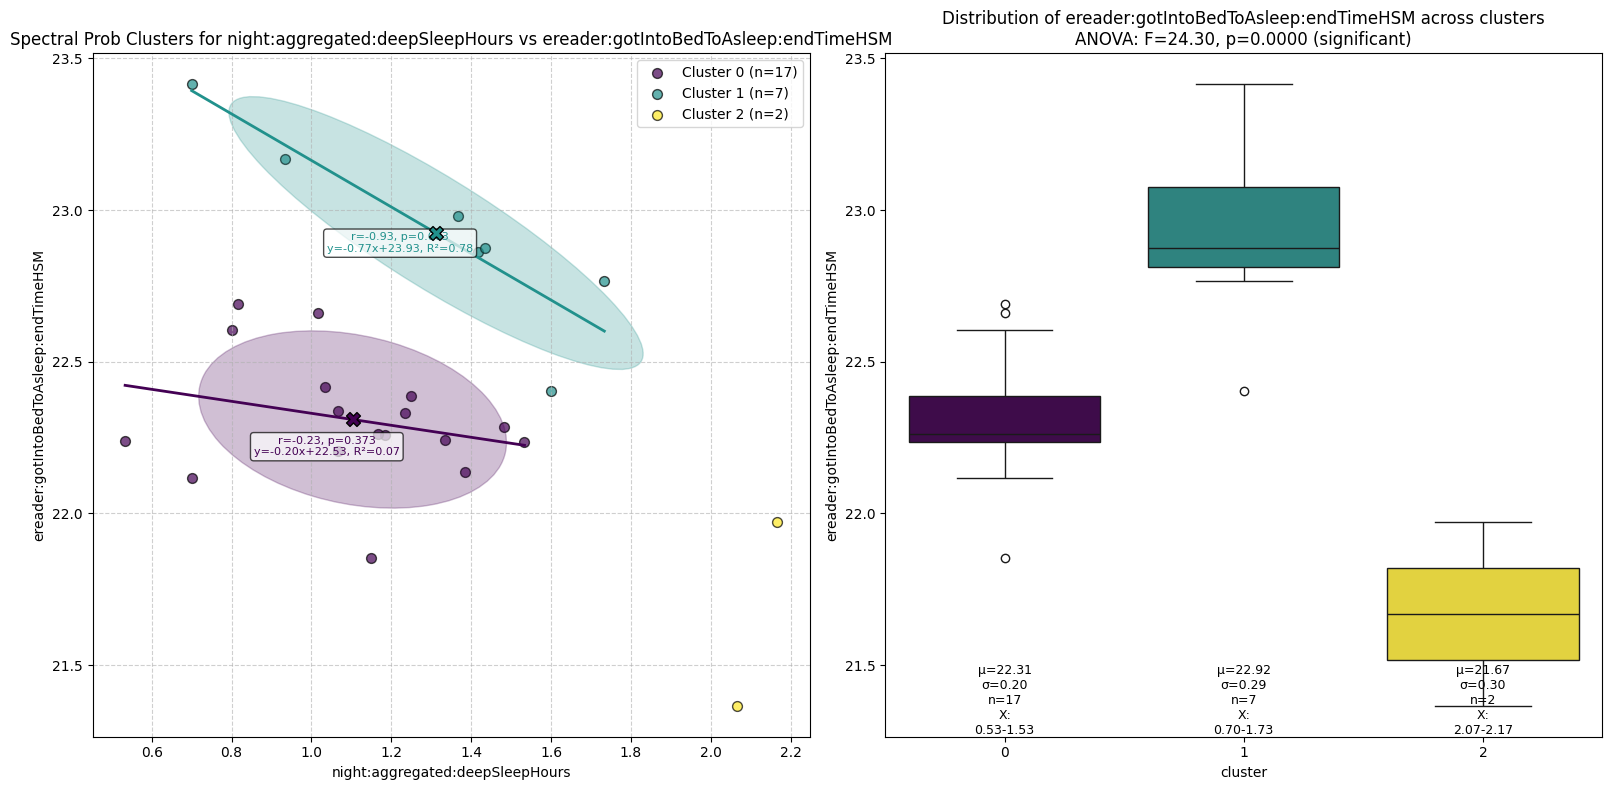

  ANOVA results for Spectral Prob:
    F-value: 24.3029
    p-value: 0.0000
    Significant difference: True
    Tukey HSD post-hoc test:


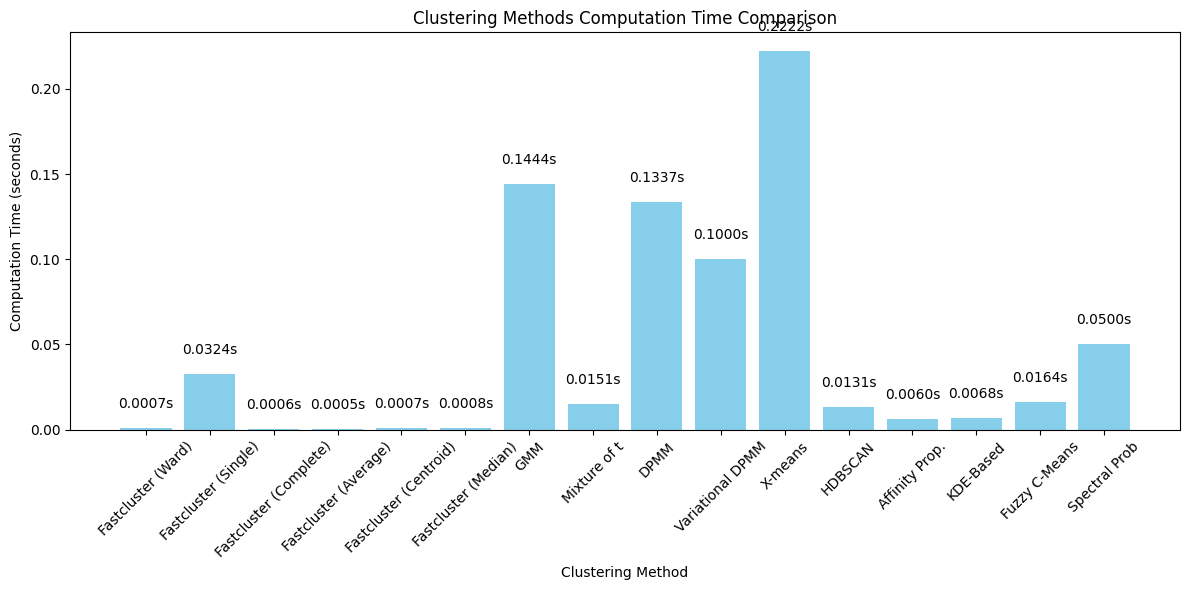

In [ ]:
# import stats_clustering
# reload(stats_clustering)


# models = stats_clustering.compare_all_clustering_methods(df, c1, c2, merge_clusters=False)